### Check out width distributions

In [1]:
# import fiona
from shapely.geometry import *
from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
# import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

In [2]:
## Set-up
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/'

In [3]:
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

In [13]:
# Get slurm job index
# i = 109 # HUC4 1711, Snoqualmie
i = 4 # HUC4 0108, Connecticut

# Get current HUC2 and HUC4 IDs
hu2 = 'HUC2_' + lookup.loc[i,'HUC4'][0:2]
hu4 = 'NHDPLUS_H_' + lookup.loc[i,'HUC4'] + '_HU4_GDB'

In [14]:
# Set data filepath
file_path = os.path.join(prep_path, hu2, hu4 + '_prepped.gpkg')

In [ ]:
# fiona.listlayers(file_path)

In [ ]:
# fieldsF = ['GNIS_ID', 'GNIS_Name', 'LengthKM',  'FlowDir',
#            'WBArea_Permanent_Identifier', 'FType', 'FCode',
#            'NHDPlusID', 'VPUID', 'geometry']
# fieldsVAA = ['NHDPlusID', 'StreamOrde', 'FromNode', 'ToNode',
#             'LevelPathI', 'TerminalFl', 'TotDASqKm', 'VPUID']
# fieldsEROMMA = ['NHDPlusID', 'QBMA', 'VPUID']

In [15]:
# Read in NHD flowlines
features = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'Bin', 'geometry']
basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')

In [16]:
basin.shape

(65310, 6)

In [23]:
# Show reaches where width > length
basin[(basin['LengthKM']*1000 < basin['WidthM']) & (basin['GNIS_Name'] == 'Hearthstone Brook')]

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry


In [8]:
# Drop reaches that are shorter than their width
# NO LONGER NEEDED--MOVED THIS TO prepNHD
# basin = basin[basin['LengthKM']*1000 > basin['WidthM']]

In [9]:
basin.shape

(238500, 6)

In [ ]:
# for binn in bins:
#     print(basin.loc[basin['Bin'] == binn].sample(n=1))

#### Width analysis

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
basin.plot(ax=ax)
# basin[basin['LengthKM'] == 16.387000].plot(color='r', ax=ax)

In [ ]:
basin.Bin.unique()

In [ ]:
# order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
#          '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
#          '(100, 150]', '(150, 200]']
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(80, 90]']

In [ ]:
basin['Bin'].value_counts().loc[order].plot.bar(color='k')
plt.title(hu4)
plt.xlabel('Bankfull widths (m)')
plt.ylabel('Number of reaches')

In [ ]:
min_width = basin.groupby('Bin').min('LengthKM')['LengthKM']
mean_width = basin.groupby('Bin').mean('LengthKM')['LengthKM']
med_width = basin.groupby('Bin').median('LengthKM')['LengthKM']
max_width = basin.groupby('Bin').max('LengthKM')['LengthKM']

print('Reach length by bin\n')
print('Width (m)\t' +  'Min(m)\t' + 'Mean(m)\t' + 'Med(m)\t' + 'Max(m)\t')
for i in order:
    print(i + ':\t' + str(round(min_width.loc[i], 3)*1000) + '\t' +
          str(round(mean_width.loc[i], 3)*1000) + '\t' +
          str(round(med_width.loc[i], 3)*1000) + '\t' +
          str(round(max_width.loc[i], 3)*1000))

In [ ]:
basin[basin['LengthKM'] > 8.0]

In [ ]:
reach = basin.loc[basin['LengthKM'] > 10]

In [ ]:
reach

In [ ]:
test = reach.LengthKM.item()

In [ ]:
print(reach.GNIS_Name.item() + ", " + reach.Permanent_Identifier.item() +
          ", Length: " + str(round(reach.LengthKM.item(),3)) + "km, Width: " +
          str(round(reach.WidthM.item(),3)) + 'm')

In [ ]:
reach = basin[basin['LengthKM'] > 10];

fig, ax = plt.subplots(figsize=(15,15))
basin.plot(ax=ax)
reach.plot(color='r', ax=ax)
plt.title(reach.GNIS_Name.item() + ", " + reach.Permanent_Identifier.item() +
          ", Length: " + str(round(reach.LengthKM.item(),3)) + "km, Width: " +
          str(round(reach.WidthM.item(),3)) + 'm')

In [ ]:
basin.shape

In [ ]:
basin[basin['LengthKM']*1000 < basin['WidthM']*20]

In [ ]:
test = basin[basin['LengthKM']*1000 > basin['WidthM']]

fig, ax = plt.subplots(figsize=(15,15))
test.plot(ax=ax)
# reach.plot(color='r', ax=ax)
# plt.xlim(-13600000, -13500000)
# plt.ylim(5900000, 6000000)

#### CHOPPI DA SALAD

In [10]:
def cut(line, distance):
# Cuts a line in two at a distance from its starting point
# Returns the trimmed piece and the remainder of the linestring
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [ ]:
# def cut(line, dist, dists):
#     points = [line.interpolate(dist) for dist in dists]
#     multipoint = unary_union(points)
#     new = split(line, multipoint)
#     new = new.explode()

In [11]:
np.max(basin.LengthKM)

np.float64(10.11085088)

In [30]:
# reach = basin.loc[basin['NHDPlusID'] == 55000800282287]
reach = basin.loc[basin['LengthKM'] == 10.11085088]
# reach = basin.loc[basin['LengthKM'] == 9.656000]

In [31]:
reach

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
122007,"(0, 10]",Swan Creek,10.110851,5.500080e+13,6.688119,MULTILINESTRING Z ((-13624848.401 5966625.882 ...


In [32]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry.explode().force_2d()

In [33]:
# Extract line segment from GeoSeries
line = gs[reach.index[0]]
# line

In [34]:
# Define number of segments
n = 10
dist = line.length/n

In [35]:
line.length

14950.25404770804

In [36]:
dist

1495.025404770804

In [37]:
# Make empty list for segments
segments = []

# Segment the reach
for i in range(n):
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)
    
    # Append new segment to GeoSeries of all segments
    segments.append(new)
# reaches = gpd.GeoSeries(reaches)

In [38]:
# Check the remainder to ensure we got the entire reach
assert line.length < 1e-8

In [39]:
segments

[<LINESTRING (-13624848.401 5966625.882, -13624760.154 5966738.664, -13624741...>,
 <LINESTRING (-13624705.09 5968066.514, -13624695.384 5968156.698, -13624684....>,
 <LINESTRING (-13624760.402 5969481.218, -13624762.772 5969503.856, -13624770...>,
 <LINESTRING (-13624782.319 5970967.474, -13624782.226 5971027.678, -13624786...>,
 <LINESTRING (-13624897.295 5972390.935, -13624902.655 5972430.261, -13624901...>,
 <LINESTRING (-13624944.625 5973754.221, -13624938.673 5973774.881, -13624938...>,
 <LINESTRING (-13625087.668 5974821.904, -13625111.272 5974842.091, -13625115...>,
 <LINESTRING (-13625022.459 5976242.478, -13625022.427 5976252.468, -13625036...>,
 <LINESTRING (-13624918.619 5977653.198, -13624917.329 5977658.496, -13624905...>,
 <LINESTRING (-13624759.98 5979078.583, -13624755.429 5979089.394, -13624747....>]

<Axes: >

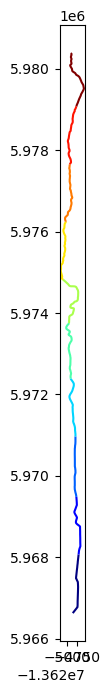

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(segments).plot(cmap='jet', ax=ax)

In [ ]:
# # Duplicate rows of original reach metadata for merging
# reach_cut = gpd.GeoDataFrame(np.repeat(a=reach, repeats=n, axis=0), columns=reach.columns,
#                             crs=reach.crs)

In [ ]:
# # Check that CRS match before merging
# assert reach_cut.crs == df.crs

In [ ]:
# # Merge the new segments onto the metadata
# reach_cut = gpd.GeoDataFrame(reach_cut.merge(right=df, how='right', left_index=True, right_index=True))

In [ ]:
# # Drop the geometry of the full reach, set segment geometry as active geometry column
# reach_cut = reach_cut.drop(columns='geometry_x').rename(columns={'geometry_y': 'geometry'})

In [29]:
d = {}

for i in range(reach_cut.shape[1]):
    d[reach_cut.iloc[:,i].name] = reach_cut.iloc[i,i]

d['geometry_full'] = d['geometry']

NameError: name 'reach_cut' is not defined

In [28]:
test = gpd.GeoDataFrame(index=range(len(segments)), data=d, geometry=segments)

NameError: name 'd' is not defined

In [ ]:
reach_cut.iloc[:,0].name

In [ ]:
# reach_cut

In [ ]:
# Buffer the reach segments by 1/2 the calculated width
# CITE BEIGER
reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
reach_cut.plot(cmap='jet', ax=ax)

# # plt.xlim(-13620000,-13619000)
# plt.ylim(5968000,5970000)

In [ ]:
# Get the bounds for Earthdata (EPSG:4326) and analysis (EPSG:3857)
bounds_proj = reach_cut.total_bounds
bounds_geo = reach_cut.to_crs(epsg=4326).total_bounds

#### Get Pixel Cloud

In [ ]:
filepath = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_011_345_239R_20240227T044209_20240227T044220_PIC0_01.nc'

In [ ]:
ds_PIXC = xr.open_mfdataset(filepath, group = 'pixel_cloud', engine='h5netcdf')

In [ ]:
ds_PIXC

In [ ]:
# # When I also filter on the qual flags like Brent does in the PO.DAAC cookbook,
# # I get no pixels
# mask = np.where(ds_PIXC.classification > 2)
# # mask = np.where(np.logical_and(ds_PIXC.classification > 2, ds_PIXC.geolocation_qual < 4))

In [ ]:
# We only want to allow pixels with layover_significant or 
# phase_noise_suspect, but so many pixels have xovercal_suspect
# this will keep those that have xovercal_suspect and/or
# layover_significant and/or phase_noise_suspect
flags = np.logical_or.reduce([ds_PIXC.geolocation_qual < 4, 
                                ds_PIXC.geolocation_qual == 64,
                                ds_PIXC.geolocation_qual == 65,
                                ds_PIXC.geolocation_qual == 66,
                                ds_PIXC.geolocation_qual == 67])

# Keep pixels where class is not land and flag is one of the above
mask = np.where(np.logical_and(ds_PIXC.classification > 1, flags))[0]

In [ ]:
gdf_PIXC = gpd.GeoDataFrame(ds_PIXC.classification[mask],
                        geometry=gpd.points_from_xy(ds_PIXC.longitude[mask],
                                                    ds_PIXC.latitude[mask]),
                        crs="EPSG:4326")
gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)

In [ ]:
gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)

#### For now: Get bounds of PIXC and crop basin to it

In [ ]:
# Get bounds of PIXC, construct polygon
bounds_PIXC = gdf_PIXC.total_bounds
poly = box(bounds_PIXC[0], bounds_PIXC[1], bounds_PIXC[2], bounds_PIXC[3])

In [ ]:
crop_basin = basin.clip(poly)

In [ ]:
bins = np.unique(crop_basin.Bin)
bins

##### To just see pixels in bounding box

In [ ]:
polygon = box(bounds_proj[0], bounds_proj[1], bounds_proj[2], bounds_proj[3])

In [ ]:
crop_PIXC = gdf_PIXC.clip(polygon)

In [ ]:
fig, ax = plt.subplots()
reach_cut.plot(cmap='jet', ax=ax)
crop_PIXC.plot(ax=ax, alpha=0.5)

#### Sjoin

In [ ]:
inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

In [ ]:
np.unique(inside.klass)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
reach_cut.plot(cmap='jet', alpha=0.5, ax=ax)
inside.plot(column=inside.klass, categorical=True, 
            markersize=3, c=inside.klass, ax=ax, legend=True)

leg1 = ax.get_legend()
leg1.set_title("Classification")

In [ ]:
counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())

In [ ]:
counts

In [ ]:
coverage = len(counts.loc[counts['count'] != 0])/len(counts.segment)

In [ ]:
coverage

In [ ]:
d = {'coverage': [0, 1, 2], 'test': 0}

In [ ]:
tt = pd.DataFrame(data=d, index=[0, 1, 2])

In [ ]:
tt

In [ ]:
# inside

#### Loop the chop

In [ ]:
def segmentReach(reach):
    ###
    
    # Convert MultiLineString Z to LineString (returns GeoSeries)
    gs = reach.geometry.explode().force_2d()
    # Extract line segment from GeoSeries
    line = gs[reach.index[0]]
    print(line.length)
    # Find length of segments
    dist = line.length/10
    print(dist)
    
    # Make empty list for segments
    segments = []
    
    # Segment the reach
    for i in range(10):
        # Chop the reach, store remainder
        new, remain = cut(line=line, distance=dist)

        # Append new segment to GeoSeries of all segments
        segments.append(new)
    
    # Check the remainder to ensure we got the entire reach
    assert linne.length < 1e-8
    del new, linne, dist
    
    # Make dict for constructing new GeoDataFrame
    d = {}
    for i in range(reach.shape[1]):
        d[reach.iloc[:,i].name] = reach.iloc[0,i]
    # Rename geometry for full reach
    d['geometry_full'] = d['geometry']
    
    # Make GeoDataFrame with new reach segments
    reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)),
                                 geometry=segments, crs=reach.crs)
    
    return reach_cut

In [ ]:
def getCoverage(gdf_PIXC, reach_cut):
    ###
    
    # BUFFER PIXELS
    
    # Get pixels in reach
    inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

    if inside.empty:
        coverage = 0
    else:    
        # Get number of pixels in each reach segment
        counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
        # Calculate coverage
        coverage = len(counts.loc[counts['count'] != 0])/len(counts.segment)
    
    return coverage

In [ ]:
# Initialize lists
coverage = []
reach_bins = []

for binn in bins:
    reach = crop_basin.loc[crop_basin['Bin'] == binn].sample(n=1)
    '{}'.format(reach.NHDPlusID)
    # break
    reach_bins.append(reach.iloc[0,0])
    
    # Get reach segments
    reach_cut = segmentReach(reach)
    
    # Get coverage for reach
    prop = getCoverage(gdf_PIXC, reach_cut)
    
    coverage.append(prop)

In [ ]:
reach

In [ ]:
n = 10

In [ ]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry.explode().force_2d()
# Extract line segment from GeoSeries
line = gs[reach.index[0]]
# Find length of segments
dist = line.length/n

In [ ]:
line.length

In [ ]:
dist

In [ ]:
# Make empty list for segments
segments = []

In [ ]:
# Segment the reach
for i in range(n):
    print(i)
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)

    # Append new segment to GeoSeries of all segments
    segments.append(new)

In [ ]:
segments

In [ ]:
# Check the remainder to ensure we got the entire reach
assert line.length < 1e-8

# Make dict for constructing new GeoDataFrame
d = {}
for i in range(reach.shape[1]):
    d[reach.iloc[:,i].name] = reach.iloc[i,i]
# Rename geometry for full reach
d['geometry_full'] = d['geometry']

# Make GeoDataFrame with new reach segments
reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)), geometry=segments)